# 고객 주요구매 색상 추출

## 1. 데이터 분석

### 1. Clustering 대상

- 고객의 주요 구매 색상을 clustering을 통해 추출하여 고객 취향 파악, 고객의 취향에 맞는 색상의 상품 추천   
- 데이터베이스의 PRDT_REVIEW 테이블에서 상품코드 기준으로 유저별 구매한 상품의 색 리스트 조회   
  → 색 리스트 값 : HSV1, HSV2, ... 데이터로 전처리 후 Clustering → 주요 구매 색 추출   
- **주요 구매 색 추출 시 주의점   
    1. 회색 계통 데이터   
        - 상품 추천 시 고객 구매 상품에 회색 계통의 상품이 많을 경우 회색 계통 상품만 추천될 가능성 有   
          → Graytone Filter 작성   
    2. 소규모 훈련 데이터(고객 구매상품 개수)   
        - 10개 미만 소량 구매한 고객이 다수   
        - 구매한 상품의 색이 서로 근접한 색이 아닐 경우 Clustering 시 유관하지 않은 색 추출될 가능성 有   
          (hsv 기준 빨간색과 초록색의 중앙 색인 노란색이 중앙값으로 추출)   
          → Color Generator 작성   

### 2.  회색조 구매상품 필터링 (Graytone Filter)

- 회색 계통 상품 추천 방지, 색 추출 시 회색조 필터링      
- HSV 회색조 판단 기준   
    1. 채도(S)가 5보다 작거나 명도(V)가 10보다 작은 경우   
    2. 채도(S)+명도(V)가 40보다 작은 경우   
    3. 채도(S)+(100-명도(V)) 혹은 (100-채도(S))+명도(V)가 15보다 작은 경우   
   
### 3. 군집화 색상 확장 (Color Generator)

- 고객 구매상품의 HSV 기준으로 색 조정 범위와 확장 규모 설정   
  ex. 빨간색 1개, 초록색 1개일 경우 빨간색 10개 초록색 10개로 색을 확장하여 군집 개수가 달라져도 각각 유관한 색 추출
- 훈련 성능 비교하여 최종 조정 수치 결정, HSV 데이터 Generating
   

---

## 2. Color Clustering 성능 평가

- 고객 별 구매상품의 색이 다르며, 구매한 상품 수가 다른 정답이 없는 Clustering   
- 따라서 실루엣계수로 성능 평가 진행   
- `실루엣 계수(Silhouette coefficient)` : 정답 정보가 없는 Clustering의 성능 평가 기준   
    - 같은 군집의 데이터가 다른 군집의 데이터보다 더 가깝다면 실수엣 계수는 양수   
    - 다른 군집의 데이터가 같은 군집의 데이터보다 더 가깝다면 실루엣 계수는 음수   
    - 잘못된 군집화에서 평균 실루엣계수가 작아져 실루엣계수가 클수록 좋은 군집화   
    
### 1. Algorithm 별 비교

1. `K-평균 군집화(K-means Clustering)`
    - 10회 훈련 시, 구분되는 색 예측 값에 차이 발생   
2. `디비스캔 군집화(DBSCAN Clustering)`
    - 10회 훈련 시, 구분되는 색 예측값은 거의 동일하나, 군집화 개수를 지정할 수 없이 4개로 고정   
    - 노이즈 개념을 활용하여 이상치 대응에 효과적이나, 색 범위는 제한되어 있기 때문에 이상치가 존재하지 않음   
    - 파라미터 조정 시 예측 값과 실루엣 계수 차이 없음   
3. `계층적 군집화(Hierarchical Clustering)`
    - 파라미터 조정 시 예측 값과 실루엣 계수 차이 없음   
4. `스펙트럴 군집화(Spectral Clustering)`
    - 파라미터(affinity) 중 'rbf'만 훈련 적용 가능   
    - 10회 훈련 시, 예측 값과 실루엣 계수 차이 없음   
5. `유사도 전파 군집화(Affinity Propagation Clustering)`
    - 메시지 전달 기법을 사용해 군집의 대표점을  찾아 스스로 군집 개수를 정함   
    - 파라미터 조정해도 스스로 정하는 클러스터 개수가 너무 많아서 훈련 목적에 부합하지 않음   
   
   
- **알고리즘 별 실루엣계수 비교**
    - 색 샘플 3개 : 실루엣계수 차이 ± 0.1   
    - 색 샘플 7개 : 실루엣계수 차이 ± 0.1 / K-means가 가장 성능이 나쁨   
    - 색 샘플 10개 : 실루엣계수 가장 좋은 알고리즘 Hierarchical, Spectral   
    → 시각화 시 가장 색이 균일하게 군집화되는 `Hierarchical`로 알고리즘 선정   

색 샘플 수|Kmeans|DBSCAN|Hierarchical|Spectral
:---:|:---:|:---:|:---:|:---:
3|0.61|0.61|0.61|0.61
7|0.48|0.55|0.54|0.54
10|0.47|0.46|0.50|0.50



### 2. 색 제너레이팅 조정 범위에 따른 성능 비교
   
- 제너레이팅 조정 값 색(H) ±10, 채도(S), 명도(V) ±5일 때 가장 실루엣 지수가 높음 → 조정 범위 (10, 5) 선정   

조정값 (규모 10j, 10j)|5, 5|10, 5|15, 5|10, 10|20, 10|30, 10|10, 20|20, 20|30, 20
:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:
실루엣계수|0.62|0.61|0.61|0.52|0.51|0.5|0.41|0.38|0.4
   
   
### 3. 색 제너레이팅 규모에 따른 성능 비교
   
- 제너레이팅 규모 값 색(H) 20j, 채도(S), 명도(V) 10j일 때 이후로 성능 지수가 오르지 않음 → 규모 값 (20j, 10j) 선정   
    
규모 (조정 범위 10, 5)|5, 5|10, 5|15, 5|10, 10|20, 10|30, 10|10, 20|20, 20|30, 20
:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:
실루엣계수|0.6|0.6|0.6|0.61|0.62|0.62|0.62|0.62|0.62
    
    
### 4. Cluster 수에 따른 비교

- 조정값 별 수식에 의한 클러스터 개수 산정   
    - 클러스터 개수 조정값 별 군집화된 색상 확인 시 7개가 가장 적정하다고 판단   
    - 클러스터 개수 조정값 n = 7   
        1. clustering 대상 색상 개수가 5 미만일 때   
            - 클러스터 수 = 색상 개수   
        2. clustering 대상 색상 개수가 5 이상이면서 (색상 개수/n)이 2 이하일 때   
            - 클러스터 수 = 5   
        3. (색상 개수/n)이 2 초과일 때   
            - 클러스터 수 = (색상 개수/n)+5   
- 클러스터 개수 조정값 별 군집화된 색상 확인 시 조정 값 7개가 가장 적정하다고 판단   
  ※ 하단 군집화 색상 이미지 참고   
   
   
### ▶ 성능 테스트 결과

1. Algorithm : `Hierarchical`   
2. 제너레이팅 조정 범위 : `H : 10`, `S, V : 5`    
3. 제너레이팅 규모 : `H : 20j`, `S, V : 10j`   
4. Cluster 조정 수치 : `7개`   
   
---
   
## 3. Cluster 대표 값(색) 선정

### Clustering 결과 Cluster별 대표 색 선정
- 군집별 중앙값(centroid) & 평균값 추출, 비교   
  : 동일한 값으로 추출되나, 평균값 연산보다 중앙값 함수 사용 시 성능(속도) 우수   
- 중앙값(centroid)으로 선정   

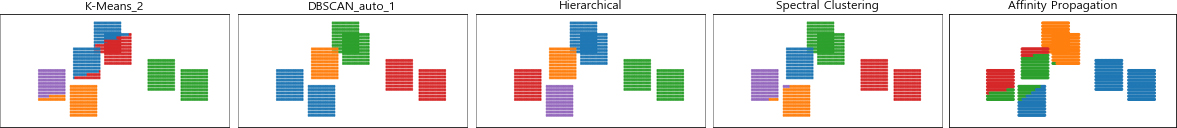

In [3]:
from IPython.display import Image

Image("Clustering Evaluation.jpg")

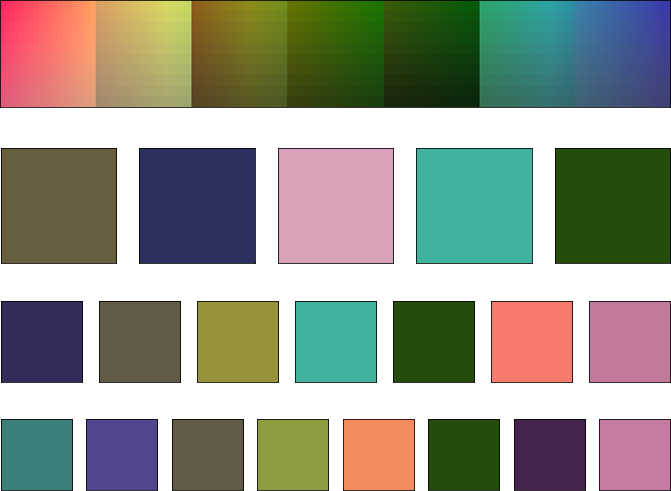

In [4]:
Image("Cluster color.jpg")